In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 1: Load the Data* and Make Transformations

*Data Source: U.S. Census Bureau and U.S. Department of Housing and Urban Development, New One Family Houses Sold: United States HSN1F, 
retrieved from FRED, Federal Reserve Bank of St. Louis; 
https://fred.stlouisfed.org/series/HSN1F, March 3

In [15]:
df= pd.read_csv('/content/new_one_family_houses.csv')
scaler = MinMaxScaler()
scaler.fit(df['Sales'].values.reshape(-1,1))
df_scaled= scaler.transform(df['Sales'].values.reshape(-1,1))
df['house_sales_scaled']= df_scaled
df.head()

,Unnamed: 0,Sales,house_sales_scaled
0,1963-01-01,591.0,0.286863
1,1963-02-01,464.0,0.173369
2,1963-03-01,461.0,0.170688
3,1963-04-01,605.0,0.299374
4,1963-05-01,586.0,0.282395


In [17]:
df.rename(columns={'Unnamed: 0':'date'}, inplace=True)


In [18]:
df.head()

,date,Sales,house_sales_scaled
0,1963-01-01,591.0,0.286863
1,1963-02-01,464.0,0.173369
2,1963-03-01,461.0,0.170688
3,1963-04-01,605.0,0.299374
4,1963-05-01,586.0,0.282395


### Task 2: Descriptive Statistics and Visualizations of the Data.

In [19]:
df.describe()

,Sales,house_sales_scaled
count,697.000000,697.000000
mean,654.005739,0.343169
std,211.685830,0.189174
min,270.000000,0.000000
25%,510.000000,0.214477
50%,625.000000,0.317248
75%,767.000000,0.444147
max,1389.000000,1.000000


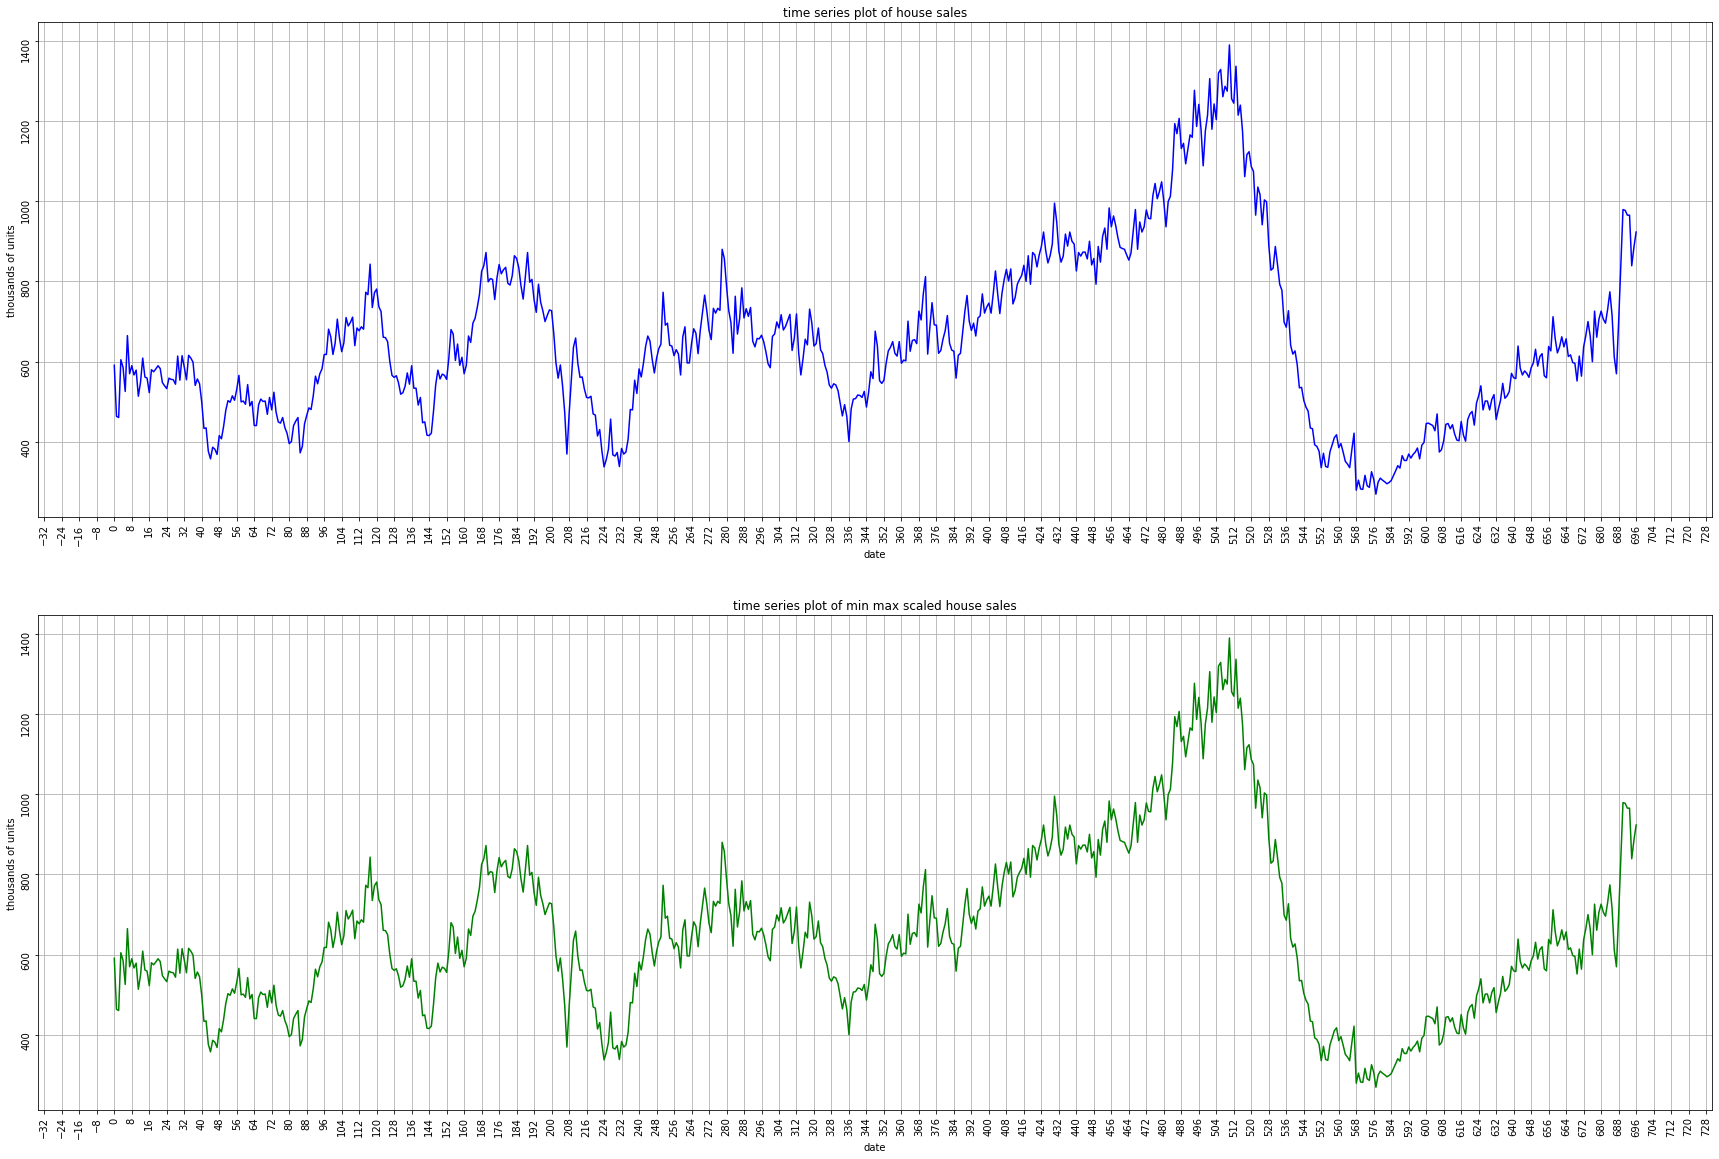

In [24]:
fig = plt.figure()
gs= GridSpec(2,1,figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M=100
xticks=ticker.MaxNLocator(M)

ax1= fig.add_subplot(gs[0,0])
ax1.plot(df.index, df['Sales'], 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('date')
ax1.set_ylabel('thousands of units')
ax1.title.set_text('time series plot of house sales')
ax1.grid(True)

ax2= fig.add_subplot(gs[1,0])
ax2.plot(df.index, df['Sales'], 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('date')
ax2.set_ylabel('thousands of units')
ax2.title.set_text('time series plot of min max scaled house sales')
ax2.grid(True)


plt.show()


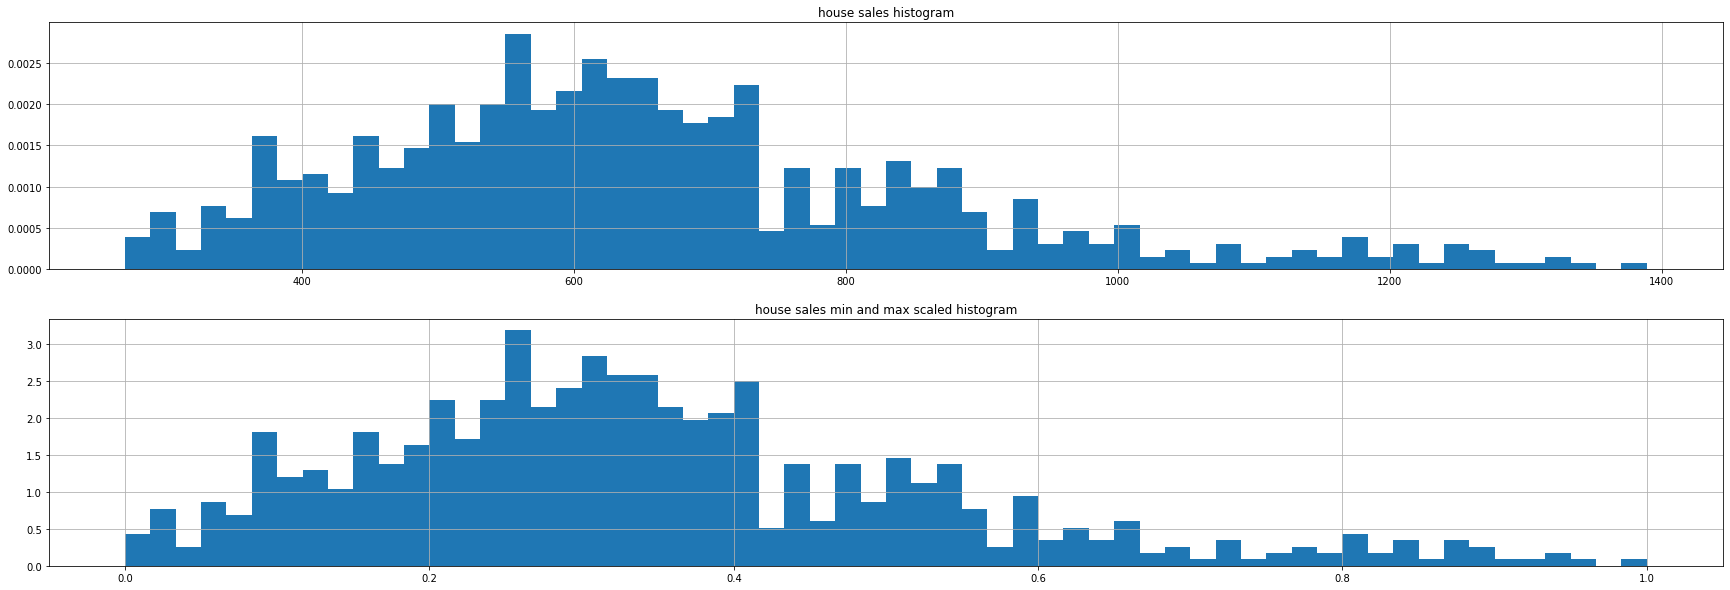

In [25]:
fig = plt.figure()
gs = GridSpec(2, 1, figure= fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1= fig.add_subplot(gs[0,0])
ax1.hist(df['Sales'], density=True, bins=60)
ax1.title.set_text('house sales histogram')
ax1.grid(True)

ax2= fig.add_subplot(gs[1,0])
ax2.hist(df['house_sales_scaled'], density=True, bins=60)
ax2.title.set_text('house sales min and max scaled histogram')
ax2.grid(True)



plt.show()

### Task 3: Unit Root Tests.

In [29]:
result = adfuller(df['Sales'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
  print(f' critical values: {key} , {value}')

ADF Statistic: -2.8085520725549906
p-value: 0.05706251126952945
 critical values: 1% , -3.4400605106273368
 critical values: 5% , -2.865824986587412
 critical values: 10% , -2.5690518865761


In [30]:
result = adfuller(df['house_sales_scaled'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
  print(f' critical values: {key} , {value}')

ADF Statistic: -2.808552072555018
p-value: 0.05706251126952565
 critical values: 1% , -3.4400605106273368
 critical values: 5% , -2.865824986587412
 critical values: 10% , -2.5690518865761


### Task 4: Autocorrelations and Partial Autocorrelations Plots.

In [31]:
acf_scaled= acf(df['house_sales_scaled'],fft=True, nlags=40)
acf_scaled_np= np.array(acf_scaled)

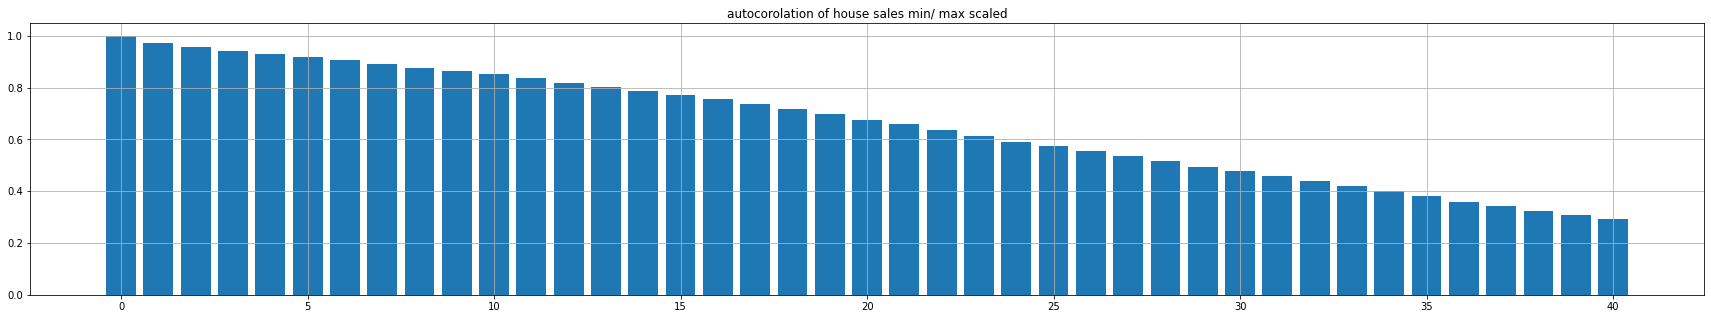

In [33]:
plt.figure(figsize=(30,5))
plt.title('autocorolation of house sales min/ max scaled')
plt.bar(range(len(acf_scaled_np)), acf_scaled_np)
plt.grid(True)

plt.show()

In [35]:
pacf_scaled= pacf(df['house_sales_scaled'], nlags=40)
pacf_scaled_np= np.array(pacf_scaled)

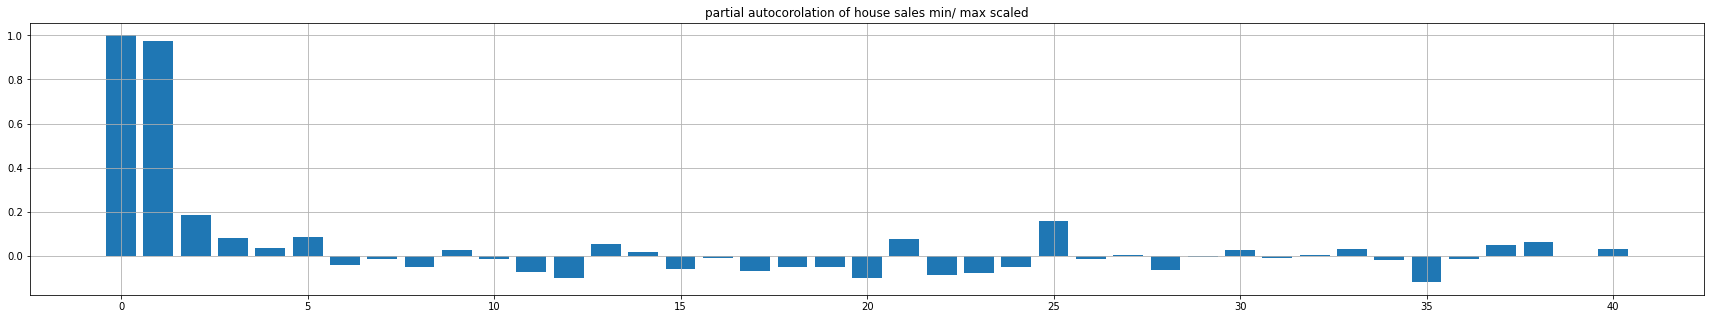

In [36]:
plt.figure(figsize=(30,5))
plt.title('partial autocorolation of house sales min/ max scaled')
plt.bar(range(len(pacf_scaled_np)), pacf_scaled_np)
plt.grid(True)

plt.show()

### Task 5: Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [37]:
size = len(df['house_sales_scaled'])
window_size = 48
batch_size = size - 2*window_size 
epochs = 200

In [44]:
date_train= df['date'].values[0:batch_size]
date_valid = df['date'].values[batch_size:]
x_train = df['house_sales_scaled'].values[0:batch_size].astype('float32')
x_valid = df['house_sales_scaled'].values[batch_size:].astype('float32')

date_train = np.reshape(date_train, (-1,1))
date_valid = np.reshape(date_valid,(-1,1))

print(f'shape of the training set date series: {date_train.shape}')
print(f'shape of the validation set date series: {date_valid.shape}')
print(' ')
print(f'shape of the training set logarithm of sales series: {x_train.shape}')
print(f'shape of the validation set logarithm of sales series: {x_valid.shape}')



shape of the training set date series: (601, 1)
shape of the validation set date series: (96, 1)
 
shape of the training set logarithm of sales series: (601,)
shape of the validation set logarithm of sales series: (96,)


In [48]:
def windowed_dataset(series, window_size= window_size, batch_size= batch_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset= dataset.window(window_size +1, shift= 1, drop_remainder= True)
  dataset= dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset= dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

dataset_train = windowed_dataset(x_train)
dataset_val = windowed_dataset(x_valid)

dataset_train = windowed_dataset(x_train)
dataset_val = windowed_dataset(x_valid)

### Task 6: Define and Estimate the LSTM.

In [50]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(8, input_shape=[None,1],return_sequences=True),
                                    tf.keras.layers.LSTM(4),
                                    tf.keras.layers.Dense(1)
                                    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer= tf.keras.optimizers.Adam()
model.compile(loss='huber_loss', optimizer=optimizer)
history= model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, verbose=1)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0832 - val_loss: 0.0706
Epoch 2/200
1/1 [==============================] - 0s 199ms/step - loss: 0.0806 - val_loss: 0.0682
Epoch 3/200
1/1 [==============================] - 0s 174ms/step - loss: 0.0781 - val_loss: 0.0659
Epoch 4/200
1/1 [==============================] - 0s 180ms/step - loss: 0.0755 - val_loss: 0.0636
Epoch 5/200
1/1 [==============================] - 0s 166ms/step - loss: 0.0730 - val_loss: 0.0614
Epoch 6/200
1/1 [==============================] - 0s 208ms/step - loss: 0.0706 - val_loss: 0.0591
Epoch 7/200
1/1 [==============================] - 0s 172ms/step - loss: 0.0681 - val_loss: 0.0569
Epoch 8/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0657 - val_loss: 0.0547
Epoch 9/200
1/1 [==============================] - 0s 174ms/step - loss: 0.0634 - val_loss: 0.0525
Epoch 10/200
1/1 [==============================] - 0s 176ms/step - loss: 0.0610 - val_loss: 0.0504
Epoch 11/200

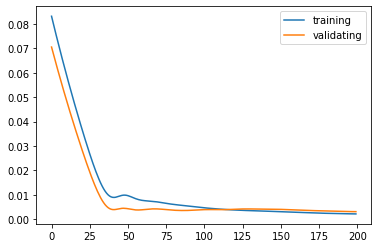

In [55]:
fig= plt.figure()
plt.plot(history.history['loss'], label= 'training')
plt.plot(history.history['val_loss'], label='validating')
plt.legend()
plt.show()

### Task 7: Forecast the LSTM on the Validation Set and Assess Accuracy.

In [58]:
def model_forcasts(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size, shift=1, drop_remainder=True)
  ds=ds.flat_map(lambda w: w.batch(window_size))
  ds= ds.batch(size).prefetch(1)
  forcast= model.predict(ds)
  return forcast


forcats= model_forcasts(model, df['house_sales_scaled'].values[:,np.newaxis], window_size)
results= forcats[batch_size - window_size: -1]
result_scaled = scaler.inverse_transform(results.reshape(-1,1))
x_valid_sacled= scaler.inverse_transform(x_valid.reshape(-1,1))

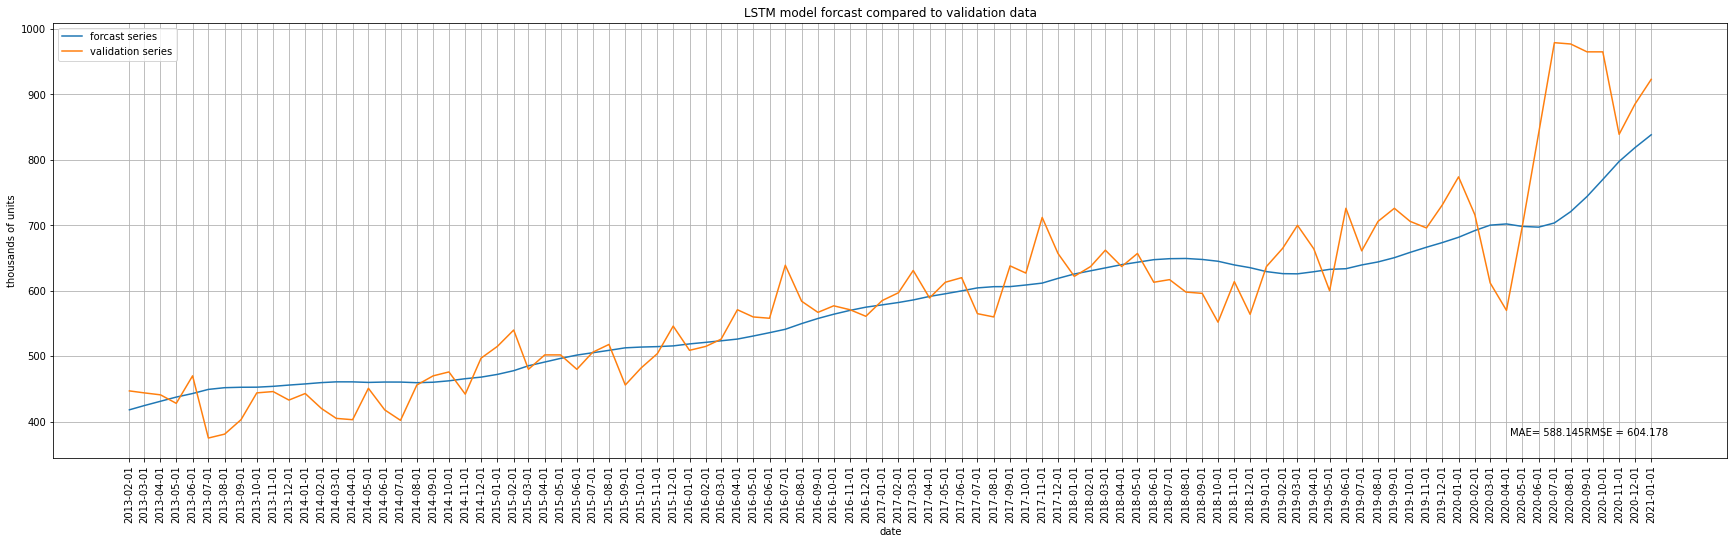

In [70]:
plt.figure(figsize=(30,8))
plt.title('LSTM model forcast compared to validation data')
plt.plot(date_valid.astype('datetime64'), result_scaled[:,0], label='forcast series')
plt.plot(date_valid.astype('datetime64'), np.reshape(x_valid_sacled,(2*window_size)), label='validation series')
plt.xlabel('date')
plt.ylabel('thousands of units')
plt.xticks(date_valid.astype('datetime64')[:, -1], rotation=90)
plt.legend(loc='upper left')

MAE = tf.keras.metrics.mean_absolute_error(x_valid_sacled[:,-1], results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(x_valid_sacled[:,-1],results[:,-1]).numpy())

text_str= "MAE= " + "{:.3f}".format(MAE)+ "RMSE = " + "{:.3f}".format(RMSE)


plt.annotate(text_str, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [75]:
print(f' MAE: {MAE:.3f}')
print(f'RMSE : {RMSE:.3f}')

 MAE: 588.145
RMSE : 604.178
